El propósito de este programa es crear un modelo de regresión logística para predecir las probabilidades de que un cliente se suscriba a un crédito a plazo. El modelo utiliza las siguientes columnas como características.

Recordemos qué es un modelo logístico:

Un modelo de regresión logística es un algoritmo de aprendizaje automático utilizado para resolver problemas de clasificación binaria


In [266]:
import math
from IPython.display import display, Math, Latex
display(Math(r"p=\frac{1}{1+e^{y}}, \ y=\Sigma_{i=1}^{n} a_{i}x_{i}+b: "))


<IPython.core.display.Math object>

  
   # bank client data:
  * 1 - age (numeric)
  * 2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
  * 3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
  * 4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
  * 5 - default: has credit in default? (categorical: "no","yes","unknown")
  * 6 - housing: has housing loan? (categorical: "no","yes","unknown")
  * 7 - loan: has personal loan? (categorical: "no","yes","unknown")
   # related with the last contact of the current campaign:
  * 8 - contact: contact communication type (categorical: "cellular","telephone")
  * 9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  * 10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  * 11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   # other attributes:
  * 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  * 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  * 14 - previous: number of contacts performed before this campaign and for this client (numeric)
  * 15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
   # social and economic context attributes
  * 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  * 17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  * 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  * 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  * 20 - nr.employed: number of employees - quarterly indicator (numeric)

  #Output variable (desired target):
  * 21 - y - has the client subscribed a term deposit? (binary: "yes","no")

Se cargan los datos usando la api de la pagina de kaggle

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d henriqueyamahata/bank-marketing

In [9]:
import zipfile
with zipfile.ZipFile("/content/bank-marketing.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [11]:
data=pd.read_csv("/content/bank-additional-full.csv", sep=";")

In [13]:
data.shape

(41188, 21)

Observamos las propiedades de nuestro dataset y si hay algun dato faltante o no

In [14]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [15]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [16]:
data_2=data.copy()

In [ ]:
data_2.columns.values.tolist()


In [68]:
data_2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_contacted
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


Por simplicidad, cambiaremos la palabra 'yes' por un 1 y la palabra 'no' por un 0.

In [43]:
data_2['y'].replace("yes", 1, inplace=True)
data_2['y'].replace("no", 0, inplace=True)

In [47]:
data_2["pdays"].unique()

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20])

Notemos que aquí tenemos un problema: cuando no se había contactado a un cliente antes, se utiliza el valor 999. Sin embargo, este valor no sería útil en el modelo. Por lo tanto, debemos cambiar este valor a 0. Además, para no perder la información sobre si el cliente había sido contactado previamente o no, crearemos una variable dummy.

In [56]:
data_2['pdays_contacted'] = (data_2['pdays'] != 999).astype(int)
data_2['pdays'].replace(999, 0, inplace=True)

De cad
Podemos crear variables dummy correspondientes para cada columna que sea categórica y que deseemos categorizar.

In [89]:
dummy_job=pd.get_dummies(data_2["job"], prefix="job")
dummy_marital=pd.get_dummies(data_2["marital"], prefix="marital")
dummy_edu=pd.get_dummies(data_2["education"], prefix="edu")
dummy_def=pd.get_dummies(data_2["default"], prefix="default")
dummy_hous=pd.get_dummies(data_2["housing"], prefix="hous")
dummy_pout=pd.get_dummies(data_2["poutcome"], prefix="loan")
dummy_loan=pd.get_dummies(data_2["loan"], prefix="loan")
dummy_cont=pd.get_dummies(data_2["contact"], prefix="conta")

In [90]:
data_3=data_2.copy()
data_3=data_3.join(dummy_job)
data_3=data_3.join(dummy_marital)
data_3=data_3.join(dummy_edu)
data_3=data_3.join(dummy_def)
data_3=data_3.join(dummy_hous)
data_3=data_3.join(dummy_pout)
data_3=data_3.join(dummy_loan)
data_3=data_3.join(dummy_cont)

In [92]:
columns=data_3.columns.values.tolist()
columnas_borrar=["job", "marital", "education", "default", "housing","poutcome","loan", "y", "duration",  'month', 'day_of_week',"contact"]
for i in columnas_borrar:
  columns.remove(i)

In [104]:
X=data_3[columns]
data_3['y'] = data_3['y'].astype(int)
Y=data_3["y"]

Utilizamos SVM para poder descartar algunas varibles con el fin de poder identificar cuales son las varible más importantes.

In [229]:
lr = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
rfe = RFE(lr, n_features_to_select=14)
rfe = rfe.fit(X,Y.values.ravel())

Creamos un df que nos diga el nombre de las columnas y su importancia en el modelo, esto es un capricho visual.

In [230]:
Ranking=pd.DataFrame(list(zip(columns,rfe.ranking_ )))
Ranking=Ranking.rename(columns={ 0: 'Columnas' })
Ranking=Ranking.rename(columns={ 1: 'Ranking' })

Ahora filtramos las columnas más importantes para incluirlas en el modelo.

In [231]:
columns_pred = Ranking[Ranking['Ranking'] == 1]['Columnas'].tolist()
columns_pred

['emp.var.rate',
 'cons.price.idx',
 'pdays_contacted',
 'job_retired',
 'job_student',
 'default_no',
 'default_unknown',
 'hous_no',
 'hous_unknown',
 'hous_yes',
 'loan_failure',
 'loan_unknown',
 'conta_cellular',
 'conta_telephone']

In [281]:
lm=LogisticRegression(solver='lbfgs', max_iter=10000)
lm.fit(data_3[columns_pred], Y)

LogisticRegression(max_iter=10000)

Podemos ver que la eficacia del modelo es buena, pero no excelente. Aun asi nos sirve para poder indetificar con gran precision las variables importantes como estan afectan al modelo.

In [282]:
lm.score(data_3[columns_pred], Y)

0.899436729144411

In [283]:
Ranking["coef"]=pd.DataFrame(np.transpose(lm.coef_))

In [284]:
Predic=pd.DataFrame(lm.predict_proba(data_3[columns_pred]))
Predic=Predic.rename(columns={1: 'Probabilidad', 0: 'Complemento'})
Predic["Y_pred"]=pd.DataFrame(lm.predict(data_3[columns_pred]))
Predic["Y_original"]=data_3["y"]
Predic

,Complemento,Probabilidad,Y_pred,Y_original
0,0.959271,0.040729,0,0
1,0.971809,0.028191,0,0
2,0.960643,0.039357,0,0
3,0.959271,0.040729,0,0
4,0.959271,0.040729,0,0
...,...,...,...,...
41183,0.386793,0.613207,1,1
41184,0.509663,0.490337,0,0
41185,0.386793,0.613207,1,0
41186,0.509663,0.490337,0,1


Usando las matrices del modelo podemos indentifar cuales casos se tomaro como negativos y cuantos como positivos. Cabe aclarar que el modelo toma como negativo cuando la probabilidad es menor a 0.5.

In [285]:
pd.crosstab(Predic["Y_original"], columns="count")

col_0,count
Y_original,
0,36548
1,4640


In [286]:
pd.crosstab(Predic["Y_pred"], columns="count")

col_0,count
Y_pred,
0,39860
1,1328


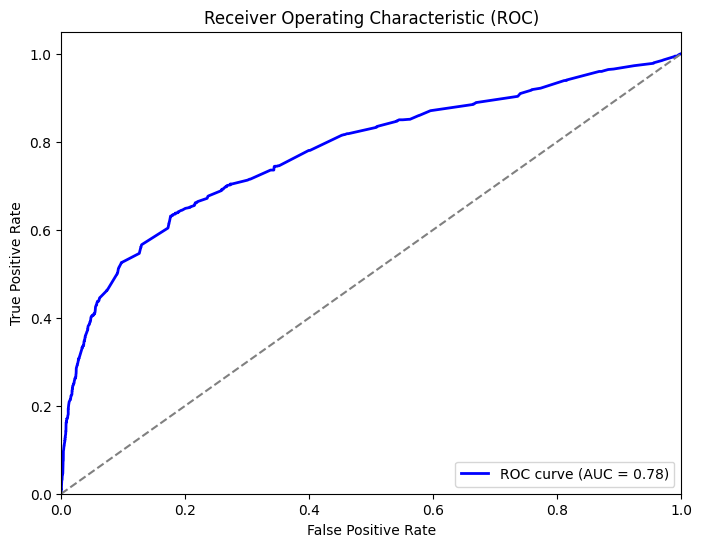

In [288]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

X_train, X_test, y_train, y_test = train_test_split(data_3[columns_pred], Y, test_size=0.2, random_state=0)

model = LogisticRegression(solver='lbfgs', max_iter=10000)
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()